# U.S. Treasury Yield Curve Forecasting using plain VAR


In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
from sklearn.decomposition import PCA
from pandas_datareader import data as pdr
import datetime
from matplotlib import pyplot as plt

## Import data

In [2]:
# Define the start and end date of the data range
start = datetime.datetime(2005, 1, 1)
end = datetime.datetime.today()

# Pull data from the FRED api using pandas_datareader
tickers = ['DGS1MO', 'DGS3MO', 'DGS6MO', 'DGS1', 'DGS2', 'DGS3', 'DGS5', 'DGS7', 'DGS10', 'DGS20', 'DGS30']
name = ['1MO', '3MO', '6MO', '1YR', '2YR', '3YR', '5YR', '7YR', '10YR', '20YR', '30YR']
df = pdr.get_data_fred(tickers, start, end).dropna()      # drop missing values
df = df.rename(columns={tickers[i]:name[i] for i in range(len(tickers))})

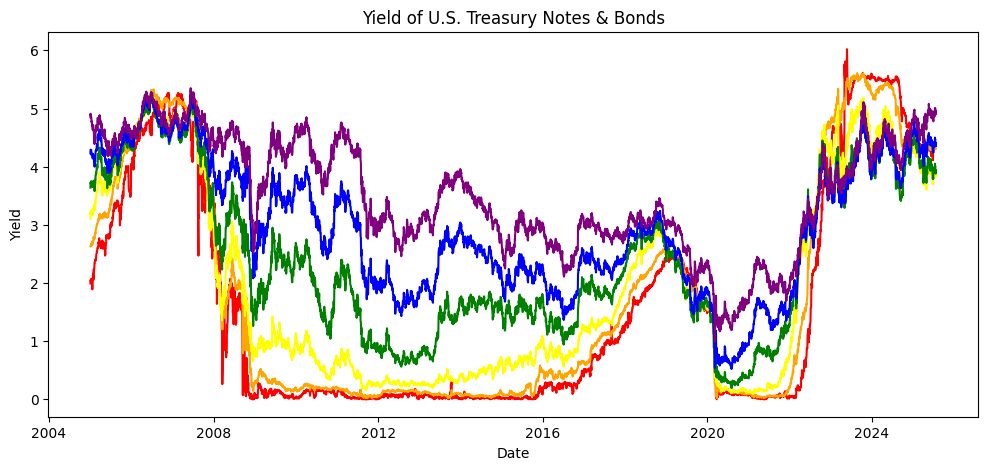

In [3]:
# Plot yields through time
plt.figure(figsize = (12,5))
plt.plot(df['1MO'], color='red')
plt.plot(df['6MO'], color='orange')
plt.plot(df['2YR'], color='yellow')
plt.plot(df['5YR'], color='green')
plt.plot(df['10YR'], color='blue')
plt.plot(df['30YR'], color='purple')
plt.xlabel('Date')
plt.ylabel('Yield')
plt.title('Yield of U.S. Treasury Notes & Bonds')
plt.show()

In [49]:
# Split into training and test data
train_portion = 0.95
n_train = int(len(df) * train_portion)
df_train = df.iloc[:n_train]
df_test = df.iloc[n_train:]

## PCA Analysis

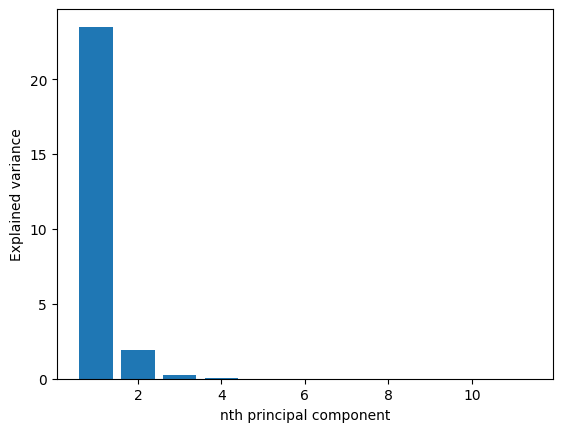

In [50]:
# Center the train data before PCA
yield_mean = df_train.mean()
df_train_c = df_train - yield_mean

# Examine the main contributing components
# Get all principal components of PCA
pca_all = PCA(n_components=df.shape[1])
pca_all.fit(df_train_c)
loadings = pca_all.components_

# Plot explained variance of each component
explained_var = pca_all.explained_variance_
plt.bar(np.arange(1,12),explained_var)
plt.xlabel('nth principal component')
plt.ylabel('Explained variance')
plt.show()


In [51]:
# Get the first three components
pca = PCA(n_components=3)
pca.fit(df_train_c)
loadings = pca.components_

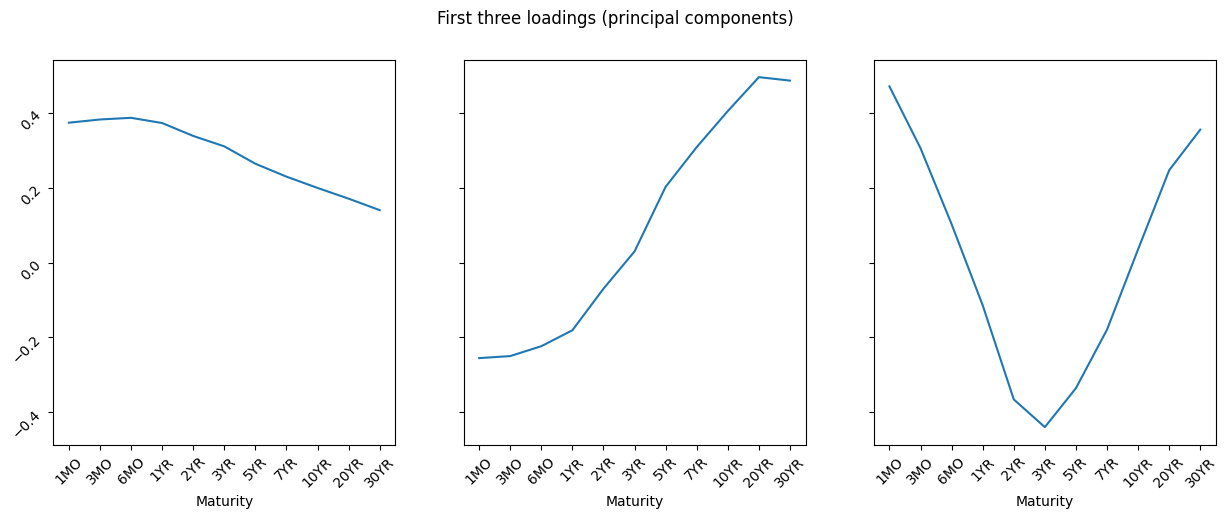

In [52]:
# Plot the first three components
fig, ax = plt.subplots(1,3,figsize=(15,5), sharey=True)
ax[0].plot(loadings[0])
ax[0].set_xticks(np.arange(0,11), name)
ax[0].tick_params(labelrotation=45)
ax[0].set_xlabel('Maturity')
ax[1].plot(loadings[1])
ax[1].set_xticks(np.arange(0,11), name)
ax[1].tick_params(labelrotation=45)
ax[1].set_xlabel('Maturity')
ax[2].plot(loadings[2])
ax[2].set_xticks(np.arange(0,11), name)
ax[2].tick_params(labelrotation=45)
ax[2].set_xlabel('Maturity')
fig.suptitle('First three loadings (principal components)')
plt.show()

In [53]:
# Represent the original training data in a basis of the first three loadings
scores = df_train_c.to_numpy() @ loadings.T
scores

array([[ 3.43596665,  1.86268754, -0.33736864],
       [ 3.61045559,  1.96476074, -0.39031132],
       [ 3.61362872,  1.93695494, -0.42931684],
       ...,
       [ 8.8078896 , -0.97814218,  0.79536438],
       [ 8.82129198, -0.93819603,  0.8014296 ],
       [ 8.80971531, -0.96230477,  0.79334005]], shape=(4885, 3))

## Test stationarity

In [54]:
# Test the stationarity of each score using ADF test
from statsmodels.tsa.stattools import adfuller

def adf_test(series, alpha=0.05):
    """Return True if stationary and False otherwise"""
    res = adfuller(series, autolag='AIC')
    pval = res[1]
    return pval < alpha

print("Stationarity")
print(f"The 1st score (level) : {adf_test(scores[:,0])}")
print(f"The 2nd score (slope) : {adf_test(scores[:,1])}")
print(f"The 3rd score (curve) : {adf_test(scores[:,2])}")

Stationarity
The 1st score (level) : False
The 2nd score (slope) : False
The 3rd score (curve) : False


In [55]:
# Take the difference series and recheck
scores_diff = []
for i in range(1,len(scores)):
    scores_diff.append(scores[i]-scores[i-1])
    
scores_diff = np.array(scores_diff)

print("Stationarity")
print(f"The 1st score_diff : {adf_test(scores_diff[:,0])}")
print(f"The 2nd score_diff : {adf_test(scores_diff[:,1])}")
print(f"The 3rd score_diff : {adf_test(scores_diff[:,2])}")

Stationarity
The 1st score_diff : True
The 2nd score_diff : True
The 3rd score_diff : True


## Forcasting using VAR (Vector Autoregression)

We use two versions: 
1. Fitting VAR using scores (nonstationary)
2. Fitting VAR using scores_diff (stationary)

In [56]:
# Use VAR (Vector Autoregression) to model the dynamics of the difference of scores
var_model_1 = VAR(scores)
var_model_2 = VAR(scores_diff)

maxlag = 15
var_res_1 = var_model_1.fit(maxlags=maxlag, ic='aic')
var_res_2 = var_model_2.fit(maxlags=maxlag, ic='aic')      # Set max la = 15

#var_res_1.summary()

In [57]:
# Forecast score using the fitted VAR model

# Version 1
score_fore_1 = var_res_1.forecast(scores[-maxlag:], steps=len(df_test))

# Version 2
score_diff_fore = var_res_2.forecast(scores_diff[-maxlag:], steps=len(df_test))
score_fore_2 = []
current_score = scores[-1]
for i in range(len(df_test)):
    next_score = current_score + score_diff_fore[i]
    score_fore_2.append(next_score)
    current_score = next_score
score_fore_2 = np.array(score_fore_2)
    
# Transform the forecasted scores back to yields
yield_fore_1 = yield_mean + pd.DataFrame(score_fore_1 @ loadings, columns=df.columns, index=df_test.index)
yield_fore_2 = yield_mean + pd.DataFrame(score_fore_2 @ loadings, columns=df.columns, index=df_test.index)

In [58]:
# Compare the forecasted yields with the test data

# Mean square error
MSE_1 = np.mean(np.sum((yield_fore_1.to_numpy() - df_test.to_numpy())**2, axis=1))
MSE_2 = np.mean(np.sum((yield_fore_2.to_numpy() - df_test.to_numpy())**2, axis=1))

print('Mean Square Error')
print(f'Fitting VAR using scores :               {MSE_1}')
print(f'Fitting VAR using score differences :    {MSE_2}')

Mean Square Error
Fitting VAR using scores :               1.2101804737438449
Fitting VAR using score differences :    4.956436133623896


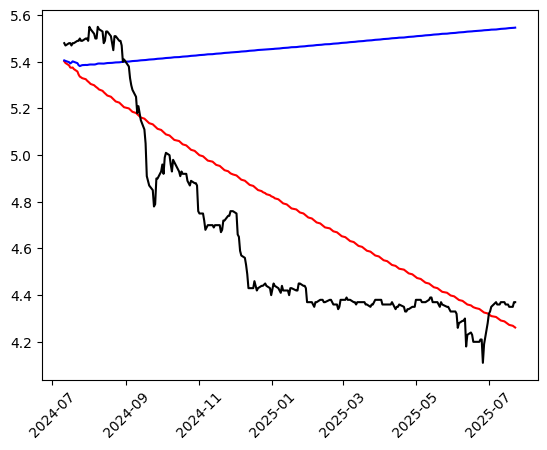

In [59]:
# Plot the forecasted vs actual 1-month yield
plt.plot(yield_fore_1['1MO'], color='red')
plt.plot(yield_fore_2['1MO'], color='blue')
plt.plot(df_test['1MO'], color='black')
plt.tick_params('x', labelrotation=45)
plt.show()

## Conclusion

From observation, fitting VAR to stationary score differences leads to a better storm-term prediction, but performs badly in long-term prediction. Fitting VAR to unstationary scores leads to a way better long-term prediction over all and gets a lower MSE.

It is obvious that VAR can't account for the instantaneous noise, but it captures the trend well enough.